In [1]:
import pandas as pd

In [2]:
import numpy as np
import os

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"  # TF will not use all memory
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers

print('Using TensorFlow version',tf.__version__)

Using TensorFlow version 2.9.1


In [5]:
tf.config.list_physical_devices('GPU')

2022-06-08 21:17:48.103115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-08 21:17:48.180093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-06-08 21:17:48.180107: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

In [6]:
class Config:
    base_dir = './'
    data_dir = 'amex-default-prediction/'
    prc_data_dir = 'processed_data/data/'
    
    feat_dim = 188
    embed_dim = 64  # Embedding size for attention
    num_heads = 4  # Number of attention heads
    ff_dim = 128  # Hidden layer size in feed forward network inside transformer
    dropout_rate = 0.3
    num_blocks = 2

In [7]:
cfg = Config()

#### Read Data ####

In [8]:
train_df = pd.read_csv(cfg.data_dir + 'train_data.csv', nrows=20)

In [9]:
train_df.head(1)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.00061,0.002674


#### Model ####

In [10]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(feat_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [11]:
def build_model():
    
    # INPUT EMBEDDING LAYER
    inp = layers.Input(shape=(13,188))
    embeddings = []
    for k in range(11):
        emb = layers.Embedding(10,4)
        embeddings.append( emb(inp[:,:,k]) )
    x = layers.Concatenate()([inp[:,:,11:]]+embeddings)
    x = layers.Dense(cfg.feat_dim)(x)
    
    # TRANSFORMER BLOCKS
    for k in range(cfg.num_blocks):
        x_old = x
        transformer_block = TransformerBlock(cfg.embed_dim, cfg.feat_dim, cfg.num_heads, cfg.ff_dim, cfg.dropout_rate)
        x = transformer_block(x)
        x = 0.9*x + 0.1*x_old # SKIP CONNECTION
    
    # CLASSIFICATION HEAD
    x = layers.Dense(64, activation="relu")(x[:,-1,:])
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs=inp, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(loss=loss, optimizer = opt)
        
    return model

In [12]:
model = build_model()

2022-06-06 23:00:34.979053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# model.summary()

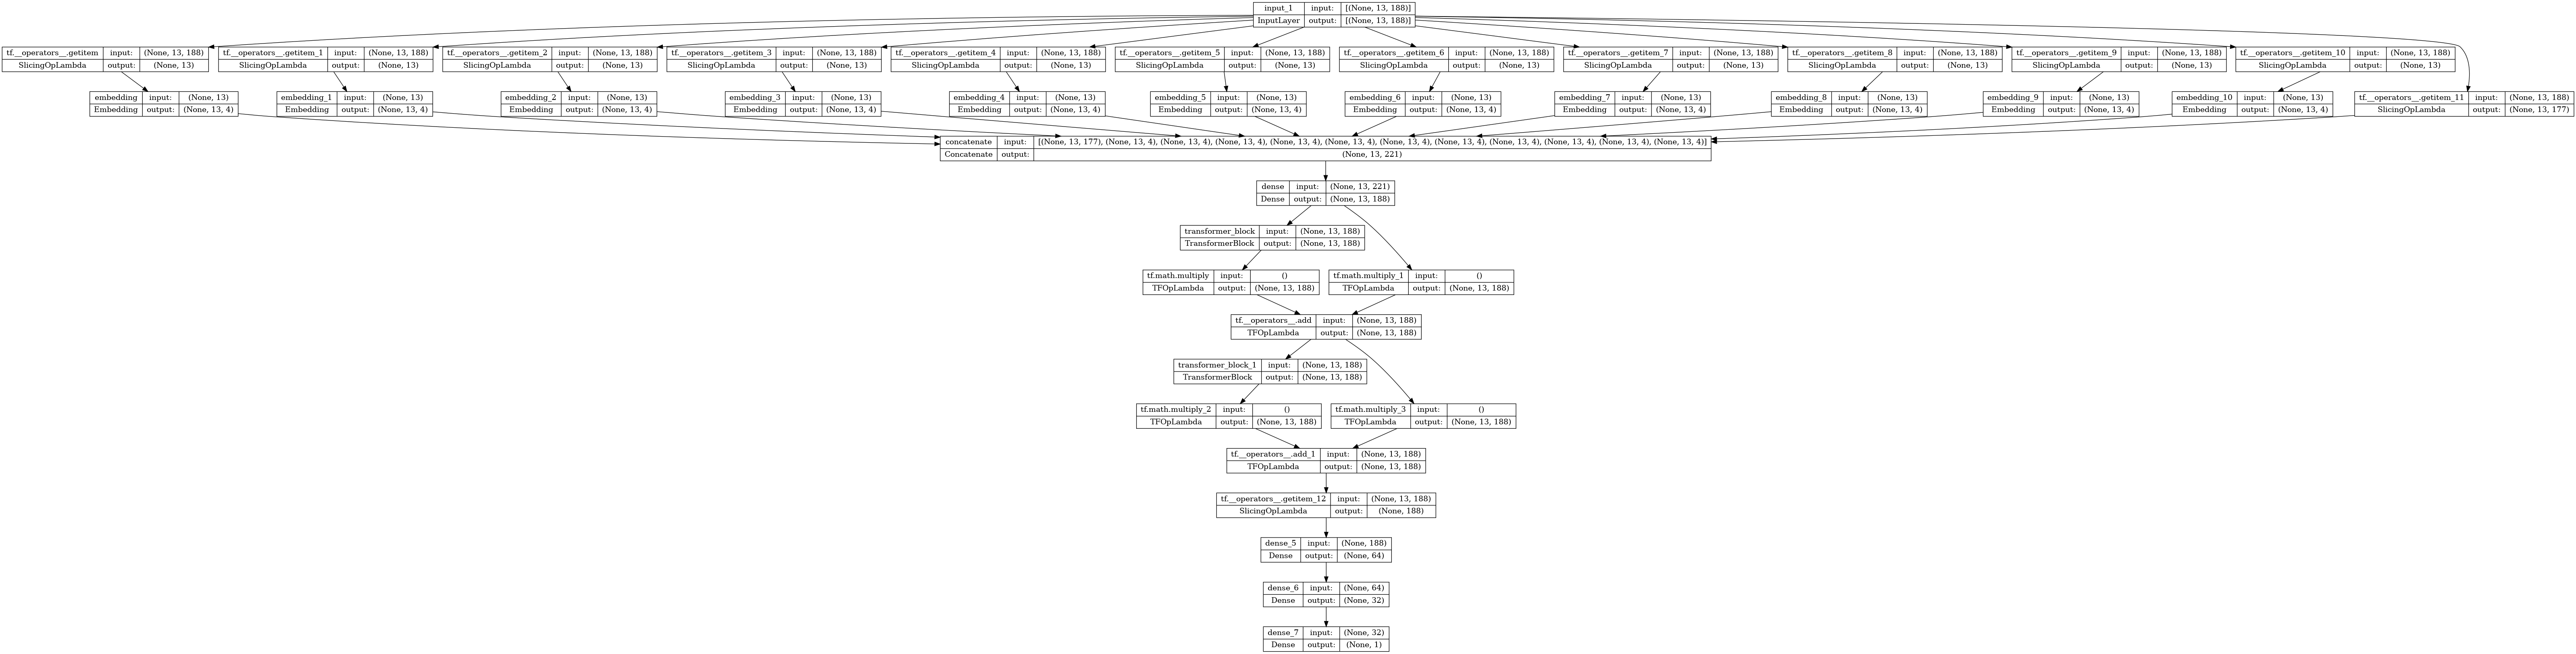

In [15]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)